# Generate new samples

Firstly, to generate meaningful data, an RBM needs to be trained. Please refer to the tutorials 1 and 2 on training an RBM if how to train an RBM using qucumber is unclear. An RBM with a positive-real wavefunction describing a transverse-field Ising model (TFIM) with 10 sites has already been trained in the first tutorial, with the parameters of the machine saved to *../01_TrainPosRealWavefunction/saved_params.pt*. The *autoload* function can be employed here to instantiate the corresponding *PositiveWavefunction* object.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

from qucumber.nn_states import PositiveWavefunction

from qucumber.observables import Observable

import quantum_ising_chain
from quantum_ising_chain import TFIMChainEnergy

nn_state = PositiveWavefunction.autoload("../01_TrainPosRealWavefunction/saved_params.pt")

A *PositiveWavefunction* object has a property called *sample* that takes in the following arguments.

1. **k**: the number of Gibbs steps to perform to generate the new samples
2. **num_samples**: the number of new data points to be generated

In [2]:
new_samples = nn_state.sample(k=100, num_samples=10000)
print (new_samples)

tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 0., 1., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.]], dtype=torch.float64)


With the newly generated samples, the user can now easliy calculate observables that do not require any details associated with the RBM. A great example of this is the magnetization. To calculate the magnetization, the newly-generated samples must be converted to $+/-1$ from 1 and 0, respectively. The function below does the trick.

In [3]:
def to_pm1(samples):
    return samples.mul(2.).sub(1.)

Now, the magnetization is calculated as follows.

In [4]:
def Magnetization(samples):
    return to_pm1(samples).mean(1).abs().mean()

magnetization = Magnetization(new_samples).item()

print ("Magnetization = %.5f" % magnetization)

Magnetization = 0.55238


The exact value for the magnetization is 0.5610. 

The magnetization and the newly-generated samples can also be saved to a pickle file along with the RBM parameters in the *PositiveWavefunction* object.

In [5]:
nn_state.save("saved_params_and_new_data.pt", metadata={"samples":new_samples, "magnetization": magnetization})

The *metadata* argument in the *save* function takes in a dictionary of data that you would like to save on top of the RBM parameters.

# Calculate an observable using the *Observable* module
## Custom observable
Qucumber has a built-in module called *Observable* which makes it easy for the user to compute any arbitrary observable from the RBM. To see the the *Observable* module in action, an example observable called *PIQuIL*, which inherits properties from the *Observable* module, is shown below. 

The *PIQuIL* observable takes an $S^z$ measurement at a site and multiplies it by the measurement two sites from it. There is also a parameter, *P*, that determines the strength of each of these interactions. For example, for the dataset $(-1,1,1,-1), (1,1,1,1)$ and $(1,1,-1,1)$ with P = 2, the *PIQuIL* for each data point would be $\left( 2(-1\times1) + 2(1\times-1) = -4 \right), \left( 2(1\times1) + 2(1\times1) = 4 \right)$ and $\left( 2(1\times-1) + 2(1\times1) = 0 \right)$, respectively.

In [6]:
class PIQuIL(Observable):
    
    def __init__(self, P):
        super(PIQuIL, self).__init__()
        self.P = P
    
    # Required : function that calculates the PIQuIL. Must be named "apply"
    def apply(self, nn_state, samples):
        to_pm1(samples)
        interaction_ = 0
        for i in range(samples.shape[-1]):
            if (i+3) > samples.shape[-1]:
                continue
            else:
                interaction_ += (self.P*samples[:,i]*samples[:,i+2])
    
        return interaction_
    
P = 0.05
piquil = PIQuIL(P)

The *apply* function is contained in the *Observable* module, but is overwritten here. The *apply* function is the function in *Observable* that will compute the observable itself and must take in the RBM (*nn_state*) and a batch of samples as arguments. Thus, any new class inheriting from *Observables* that the user would like to define must contain a function called *apply* that calculates this observable. 

Although the *PIQuIL* observable could technically be computed without the use of the *Observable* module since it does not ever use the RBM (*nn_state*), it is still nonetheless a constructive example.

The real power in the *Observable* module is in the ability for the user to easily compute statistics of the observable. Since we have already generated new samples of data, the *PIQuIL* observable's mean, standard error and variance on the new data can be calculated with the *statistics_from_samples* function in the *Observable* module. The user must simply give the RBM and the samples as arguments. 

In [7]:
piquil_stats1 = piquil.statistics_from_samples(nn_state, new_samples)

The *statistics_from_samples* function returns a dictionary containing the mean, standard error and the variance with the keys "mean", "std_error" and "variance", respectively.

In [8]:
print ('Mean PIQuIL: %.4f' % piquil_stats1['mean'], '+/- %.4f' % piquil_stats1['std_error'])
print ('Variance: %.4f' % piquil_stats1['variance'])

Mean PIQuIL: 0.1437 +/- 0.0014
Variance: 0.0191


However, if the user did not have samples generated already, that is no problem. The *statistics* function in the *Observable* module will generate new samples internally and compute the mean, standard error and variance on those samples. Since the samples are not an argumets in the *statistics* function, the user must now give the following additional arguments to the *statistics* function to generate the new samples. 

- **num_samples**: the number of samples to generate internally
- **num_chains**: the number of Markov chains to run in parallel (default = 0)
- **burn_in**: the number of Gibbs steps to perform before recording any samples (default = 1000)
- **steps**: the number of Gibbs steps to perform between each sample (default = 1)

The *statistics* function will also return a dictionary containing the mean, standard error and the variance with the keys "mean", "std_error" and "variance", respectively.

In [9]:
num_samples = 10000
burn_in     = 100
steps       = 100

piquil_stats2 = piquil.statistics(nn_state, num_samples, burn_in=burn_in, steps=steps)
print ('Mean PIQuIL: %.4f' % piquil_stats2['mean'], '+/- %.4f' % piquil_stats2['std_error'])
print ('Variance: %.4f' % piquil_stats2['variance'])

Mean PIQuIL: 0.1410 +/- 0.0014
Variance: 0.0190


## TFIM Energy
Some observables cannot be computed directly from samples, but instead depend on the RBM as previously mentioned. For example, the magnetization of the TFIM simply depends on the samples the user gives as input. Whereas the TFIM energy is much more complicated. An example for the computation of the energy is provided in the python file quantum_ising_chain.py*, which takes advantage of qucumber's *Observable* module.

*quantum_ising_chain* comprises of a class that computes the energy of a TFIM (*TFIMChainEnergy*) that inherits properties from the *Observables* module. To instantiate a *TFIMChainEnergy* object, the $\frac{h}{J}$ value must be specified. The trained RBM parameters are from the firs tutorial, where the example data was from the TFIM with 10 sites at its critical point ($\frac{h}{J}=1$). 

In [10]:
h = 1

tfim_energy = TFIMChainEnergy(h)

To go ahead and calculate the mean energy and its standard error from the previously generated samples (new_samples), the *statistics_from_samples* function in the *Observable* module is called upon.

In [11]:
energy_stats = tfim_energy.statistics_from_samples(nn_state, new_samples)
print ("Mean: %.4f" % energy_stats['mean'], '+/- %.4f' % energy_stats['std_error'])
print ('Variance: %.4f' % energy_stats['variance'])

Mean: -1.2349 +/- 0.0005
Variance: 0.0022


The exact value for the energy is -1.2381. 

To illustrate how quickly the energy converges as a function of the sampling step (i.e. the number of Gibbs steps to perform to generate a new batch of samples), *steps*, the code below will do the trick. Please note that the samples generated previously (new_samples) are not used here; new samples are generated. 

Text(0,0.5,'% Error in Energy')

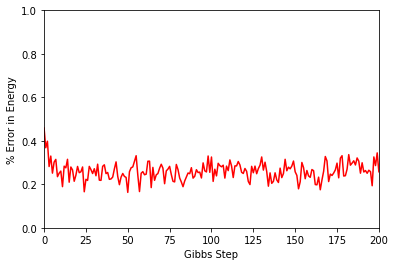

In [12]:
steps       = 200
num_samples = 10000

dict_observables = quantum_ising_chain.Convergence(nn_state, tfim_energy, num_samples, steps)

energy     = dict_observables["energies"]
err_energy = dict_observables["error"]

step = np.arange(steps + 1)

E0 = -1.2381

ax = plt.axes()
ax.plot(step, abs((energy-E0)/E0)*100, color='red')
ax.set_xlim(0, steps)
ax.set_ylim(0, 1)
ax.set_xlabel("Gibbs Step")
ax.set_ylabel("% Error in Energy")

One can see a brief transient period in the magnetization observable, before the state of the machine "warms up" to equilibrium.  After that, the values fluctuate around the calculated mean.

### Adding observables

One may also add / subtract observables with the new observable also retaining the same properties in the *Observables* module. For instance, a new observable can be defined by adding the TFIM energy observable with the PIQuIL observable multiplied by some arbitrary scalar.

In [13]:
new_obs = tfim_energy + 0.01*piquil

The same statistics of this new observable can also be calculated.

In [14]:
new_obs_stats = new_obs.statistics_from_samples(nn_state, new_samples)
print ("Mean: %.4f" % new_obs_stats['mean'], '+/- %.4f' % new_obs_stats['std_error'])
print ('Variance: %.4f' % new_obs_stats['variance'])

Mean: -1.2334 +/- 0.0005
Variance: 0.0022


## Template for your custom observable
Here is a generic template for you to try using the *Observable* module yourself.

In [15]:
# imports

from qucumber.observables import Observable #required

class YourObservable(Observable):

    def __init__(self, num_samples, your_constants):
        super(YourObservable, self).__init__()
        self.num_samples    = num_samples
        self.your_constants = your_constants
        
    def calculate_your_observable(self, generated_samples):
    
        # insert how to calculate your observable here
        
        # return a torch tensor containing the observable for each data point
        return your_observable
        
    def apply(self, nn_state, generated_samples): 
        # arguments of "apply" must be in that order
        return self.calculate_your_observable(generated_samples)   